#Method 1 : Word frequency-based Approach


###Mounting and sampling the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

# Load the dataset
train_data_path = '/content/drive/My Drive/data-train.csv'
train_df = pd.read_csv(train_data_path)

# Display the first few rows to verify the data is loaded correctly
print("First few rows of the dataset:")
print(train_df.head())

# Check the number of rows in the dataset
dataset_size = train_df.shape[0]
print(f"Total number of essays in the dataset: {dataset_size}")

# Set the sample size to be the smaller of 24,000 or the dataset size
sample_size = min(24000, dataset_size)

# Randomly sample essays from the dataset
sampled_df = train_df.sample(n=sample_size, random_state=42).reset_index(drop=True)

# Extract the 'full_text' column from the sampled dataset
essays = sampled_df['full_text']

# Display number of sampled essays
print(f"Number of essays sampled: {sampled_df.shape[0]}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
First few rows of the dataset:
  essay_id                                          full_text  score
0  000d118  Many people have car where they live. The thin...      3
1  000fe60  I am a scientist at NASA that is discussing th...      3
2  001ab80  People always wish they had the same technolog...      4
3  001bdc0  We all heard about Venus, the planet without a...      4
4  002ba53  Dear, State Senator\n\nThis is a letter to arg...      3
Total number of essays in the dataset: 17307
Number of essays sampled: 17307


## Filter and Remove the duplicates from the dataset

In [4]:
# Count the number of essays containing "PROPER_NAME"
num_essays_with_proper_name = train_df[train_df['full_text'].str.contains("PROPER_NAME", na=False)].shape[0]

# Count the number of duplicate essays based on 'full_text'
num_duplicates = train_df.duplicated(subset='full_text').sum()

# Remove essays containing "PROPER_NAME" and remove duplicates
filtered_df = train_df[~train_df['full_text'].str.contains("PROPER_NAME", na=False)].drop_duplicates(subset='full_text')

# Count the number of essays after filtering
num_essays_after_filtering = filtered_df.shape[0]

# Output the results
print(f"Number of essays containing 'PROPER_NAME': {num_essays_with_proper_name}")
print(f"Number of duplicate essays: {num_duplicates}")
print(f"Number of essays after filtering: {num_essays_after_filtering}")


Number of essays containing 'PROPER_NAME': 279
Number of duplicate essays: 0
Number of essays after filtering: 17028


#Create word frequency vectors and calculate cosine similarity

###Using **CountVectorizer** to convert each essay into a vector representing the word frequency.
###Calculate the **cosine** similarity between all the essays to identify the most similar pairs.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Use all available essays or limit to 24,000 if more are present
sample_size = min(10000, filtered_df.shape[0])
sampled_df = filtered_df.sample(n=sample_size, random_state=42).reset_index(drop=True)

# Extract the 'full_text' column from the sampled dataset
essays = sampled_df['full_text']

# Create vectors using CountVectorizer
vectorizer = CountVectorizer(max_features=10000)
essay_vectors = vectorizer.fit_transform(essays)

# Calculate cosine similarity for the sampled essays
print("Calculating pairwise cosine similarity for the sampled essays...")
similarity_matrix = cosine_similarity(essay_vectors)

# Find the top 10 similar pairs (excluding self-pairs and exact duplicates)
num_top_pairs = 10
top_similar_pairs = []

for i in range(similarity_matrix.shape[0]):
    for j in range(i + 1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] < 1.0:  # Exclude exact duplicates (score of 1.0)
            top_similar_pairs.append((i, j, similarity_matrix[i, j]))

# Sort the pairs by similarity score in descending order and get the top pairs
top_similar_pairs = sorted(top_similar_pairs, key=lambda x: -x[2])[:num_top_pairs]

# Print the top similar pairs with their essay IDs
print("\nTop Similar Pairs of Essays among 10000 samples:")
for idx, (i, j, similarity) in enumerate(top_similar_pairs):
    essay_id_1, essay_id_2 = sampled_df.loc[i, 'essay_id'], sampled_df.loc[j, 'essay_id']
    preview_1, preview_2 = sampled_df.loc[i, 'full_text'][:100], sampled_df.loc[j, 'full_text'][:100]
    print(f"Pair {idx + 1}: Essay IDs {essay_id_1} and {essay_id_2} with Similarity Score: {similarity:.4f}")

Calculating pairwise cosine similarity for the sampled essays...

Top Similar Pairs of Essays among 10000 samples:
Pair 1: Essay IDs 29aa983 and 6d25307 with Similarity Score: 0.9583
Pair 2: Essay IDs 84a1b1a and 66ee32e with Similarity Score: 0.9544
Pair 3: Essay IDs 84a1b1a and 287ed5e with Similarity Score: 0.9542
Pair 4: Essay IDs 77b1295 and 84a1b1a with Similarity Score: 0.9536
Pair 5: Essay IDs 77b1295 and 66ee32e with Similarity Score: 0.9527
Pair 6: Essay IDs ef95422 and ea57a9c with Similarity Score: 0.9526
Pair 7: Essay IDs 5bcf9b0 and 84a1b1a with Similarity Score: 0.9510
Pair 8: Essay IDs e026924 and ebe2ce0 with Similarity Score: 0.9504
Pair 9: Essay IDs 99e37ba and ebe2ce0 with Similarity Score: 0.9500
Pair 10: Essay IDs e4cde6a and 84a1b1a with Similarity Score: 0.9498


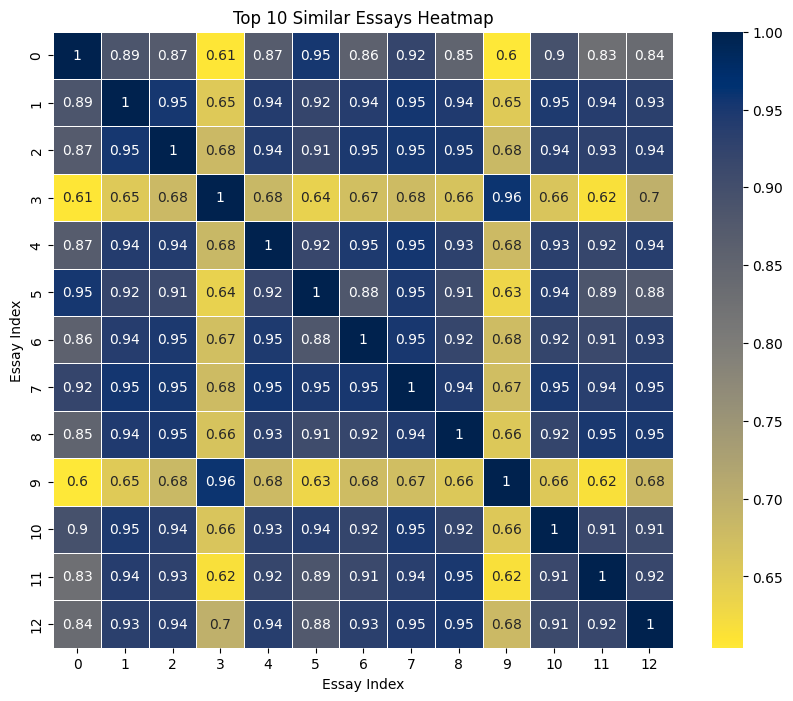

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the indices of the top 10 pairs
top_indices = list(set([index for pair in top_similar_pairs for index in pair[:2]]))

# Create a subset similarity matrix for the top indices
top_similarity_subset = similarity_matrix[np.ix_(top_indices, top_indices)]

# Create a heatmap of the subset cosine similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(top_similarity_subset, annot=True, cmap='cividis_r', linewidths=0.5)
# Add title and labels
plt.title('Top 10 Similar Essays Heatmap')
plt.xlabel('Essay Index')
plt.ylabel('Essay Index')

# Display the heatmap
plt.show()


###Extracting and Analyzing pairs with high similarity pairs

In [21]:
import itertools

# Extract pairs with high similarity scores (>= 0.8) for further analysis
high_similarity_pairs = []

for (i, j) in itertools.combinations(range(len(essays)), 2):
    if similarity_matrix[i, j] >= 0.8 and similarity_matrix[i, j] < 1.0:  # Exclude exact duplicates
        high_similarity_pairs.append((i, j, similarity_matrix[i, j]))

# Display a sample pair with high similarity but potentially different context
print("\nExample of High Similarity Scores but Different Content:")
if high_similarity_pairs:
    i, j, similarity = high_similarity_pairs[0]
    essay_id_1, essay_id_2 = sampled_df.loc[i, 'essay_id'], sampled_df.loc[j, 'essay_id']
    full_text_1, full_text_2 = sampled_df.loc[i, 'full_text'], sampled_df.loc[j, 'full_text']
    print(f"Pair: Essay IDs {essay_id_1} and {essay_id_2} with Similarity Score: {similarity:.4f}")
    print(f"Essay {essay_id_1} (Preview): {full_text_1[:200]}...")
    print(f"Essay {essay_id_2} (Preview): {full_text_2[:200]}...")



Example of High Similarity Scores but Different Content:
Pair: Essay IDs 4270df5 and 986ea58 with Similarity Score: 0.8047
Essay 4270df5 (Preview): Exploring somewhere new could be fun or could be a waste of time. Though their are many dangers in going to new places that you have never been before, it is akways worth a shot. So where are we actua...
Essay 986ea58 (Preview): Would you say that studying Venus is a worthy pursuit despite the dangers? Studying Venus can become a little difficult for people due to the dangers of the planet. Scientists are discovering further ...


###Extracting and Analyzying low similarity pairs

In [20]:
# Extract pairs with low similarity scores (<= 0.4) for further analysis
low_similarity_pairs = []

for (i, j) in itertools.combinations(range(len(essays)), 2):
    if similarity_matrix[i, j] <= 0.4:
        low_similarity_pairs.append((i, j, similarity_matrix[i, j]))

# Display a sample of 2 pairs with low similarity but potentially similar context
print("\nPairs with Low Similarity Scores but Potentially Similar Content:")
for idx, (i, j, similarity) in enumerate(low_similarity_pairs[:2]):
    essay_id_1, essay_id_2 = sampled_df.loc[i, 'essay_id'], sampled_df.loc[j, 'essay_id']
    full_text_1, full_text_2 = sampled_df.loc[i, 'full_text'], sampled_df.loc[j, 'full_text']
    print(f"\nPair {idx + 1}: Essay IDs {essay_id_1} and {essay_id_2} with Similarity Score: {similarity:.4f}")
    print(f"Essay {essay_id_1}: {full_text_1[:200]}...")
    print(f"Essay {essay_id_2}: {full_text_2[:200]}...")



Pairs with Low Similarity Scores but Potentially Similar Content:

Pair 1: Essay IDs 2cf189d and 823960d with Similarity Score: 0.3946
Essay 2cf189d: The day-to-day need of your own cars may not be as needed as you think. Cars aren't as nice as they seem to be. First of all they cause smog and pollution. But people say that not driving themselves i...
Essay 823960d: The Face is on Mars, Im a Scientist at NASA and, I can tell you that the Face is no Alien artifact. It is a landform of its own just like our Earth makes its own landforms like lakes, rivers, hills, e...

Pair 2: Essay IDs 2cf189d and a21be1a with Similarity Score: 0.3782
Essay 2cf189d: The day-to-day need of your own cars may not be as needed as you think. Cars aren't as nice as they seem to be. First of all they cause smog and pollution. But people say that not driving themselves i...
Essay a21be1a: I do not see this how a great idea because how this is going to help us?, probably we do not even want to know if we are sa